# Setup

### Initial tasks

In [1]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

### Imports

In [2]:
# built-ins
import os
import json
import math
import time
import pickle
import traceback
from os import path
from pathlib import Path
from datetime import datetime

# common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# misc
from IPython.display import display, clear_output, Markdown
from termcolor import colored

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit, GridSearchCV

# training
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### Utils / Helpers

In [3]:
def load_json(path):
    with open(path, encoding='utf-8') as f:
        return json.load(f)
    
def cprint(text, color):
    print(colored(text, color, attrs=['bold']))
    
def print_red(text):
    cprint(text, 'red')

def print_blue(text):
    cprint(text, 'blue')

In [4]:
class PrintDuration(object):
    def __enter__(self):
        self.start_time = datetime.now()
        self.last_tick = self.start_time
        self.tick_count = 0
        self.tick_times = 0
        self.out = None
        
        return self.tick
  
    def __exit__(self, exc_type, exc_value, tb):
        if exc_type is not None:
            traceback.print_exception(exc_type, exc_value, tb)
        
        self.out.update(self.printer(''))
        
    class printer(str):
        def __repr__(self):
            return self
        
    def tdformat(self, seconds):
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return '{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds))
    
    def tick(self, progress):
        now = datetime.now()
        
        # calculate
        work_time = (now - self.start_time).total_seconds()
        tick_time = (now - self.last_tick).total_seconds()
        self.tick_count += 1
        self.tick_times += tick_time

        avg_tick_time = self.tick_times // self.tick_count
        
        if progress > 0:
            total_ticks = self.tick_count // progress
            remained_ticks = total_ticks - self.tick_count
            est_remain_time = avg_tick_time * remained_ticks
        else:
            est_remain_time = 0
            
        # format
        percent = round(progress*100)
        att = self.tdformat(avg_tick_time)
        ert = self.tdformat(est_remain_time)
        
        output = f'{percent}% completed, remaining time = {ert}, average tick time = {att}'
        output = self.printer(output)
        
        if self.out is None:
            self.out = display(output, display_id=True)
        else:
            self.out.update(output)        

### Detect Env

In [5]:
ENV_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None

### Path Definitions

In [6]:
path_root = '.'
path_dataset = path.join(path_root, 'dataset')
path_csv = path.join(path_dataset, 'csv')
path_csv_output =  path_csv
path_models = path.join(path_root, 'models')

if ENV_KAGGLE:
    path_root = '/kaggle/working'
    path_dataset = '/kaggle/input/aihw2'
    path_csv = path.join(path_dataset, 'csv')
    path_csv_output = path_root
    path_models = path.join(path_root, 'models')
    
# Create directories.
Path(path_models).mkdir(parents=True, exist_ok=True)

### Configs

In [7]:
cfg_autosave_models = False
cfg_force_train = False

if ENV_KAGGLE:
    cfg_autosave_models = True
    cfg_force_train = False

# Hyperparameters

In [8]:
hp_seed = 7908
hp_cv_splits = 10
hp_test_size = 0.2

# Preprocessing

In [9]:
def map_employement_duration(entry):
    entry = str(entry).lower()
    split = entry.split(' ')
    num = split[0]
    output = entry
    
    if "-" in num:
        num = num.split("-")[1]
    
    if "weeks" in entry:
        output = float(num) / 52
    elif ("month" in entry) or ("ay" in entry):
        output = float(num) / 12
    elif ("years" in entry) or ("sene" in entry) or ("yıl" in entry):
        output = float(num)
    else:
        try:
            output = float(num)
        except:
            output = 0
        
    output = round(output, 3)
    return output

In [10]:
# read encodings
encodings = load_json(path.join(path_dataset, 'encodings.json'))

# read csvs
csv_en = pd.read_csv(path.join(path_csv, 'english.csv'), dtype=str, encoding='utf-8')
csv_tr = pd.read_csv(path.join(path_csv, 'turkish.csv'), dtype=str, encoding='utf-8')

# drop columns
csv_en.drop('Timestamp', axis=1, inplace=True)
csv_tr.drop('Timestamp', axis=1, inplace=True)

# rename columns
csv_en.rename(columns=encodings['columns']['en'], inplace=True)
csv_tr.rename(columns=encodings['columns']['tr'], inplace=True)

# encode columns
csv_en.replace(encodings['values']['en'], inplace=True)
csv_tr.replace(encodings['values']['tr'], inplace=True)

# concat csvs
df = pd.concat([csv_en, csv_tr], axis=0).reset_index(drop=True)

# fix NaNs
df.fillna(0, inplace=True)

# convert types
df['age'] = df['age'].apply(lambda x: int(x))
df['weight'] = df['weight'].apply(lambda x: int(float(x.replace(',', '.'))))
df['height'] = df['height'].apply(lambda x: int(x.translate({ord(x): '' for x in [',', '.', ' ']})))
df['employment_duration'] = df['employment_duration'].apply(map_employement_duration)

# save csv
df.to_csv(path.join(path_csv_output, 'data.csv'), index=None, header=True, encoding='utf-8-sig')
df.info()

# separate data and labels
df_data = df.drop('weight', axis=1)
df_labels = df['weight']

# convert to numpy
data = df_data.to_numpy()
labels = df_labels.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  322 non-null    int64  
 1   height               322 non-null    int64  
 2   weight               322 non-null    int64  
 3   gender               322 non-null    int64  
 4   smoking              322 non-null    int64  
 5   drinking             322 non-null    int64  
 6   exercise             322 non-null    int64  
 7   married              322 non-null    int64  
 8   children             322 non-null    int64  
 9   student              322 non-null    int64  
 10  employed             322 non-null    int64  
 11  employment_duration  322 non-null    float64
dtypes: float64(1), int64(11)
memory usage: 30.3 KB


In [11]:
df.head()

,age,height,weight,gender,smoking,drinking,exercise,married,children,student,employed,employment_duration
0,36,175,82,1,0,3,1,0,0,0,1,12.000
1,22,178,77,1,0,2,1,0,0,1,0,0.000
2,32,174,65,1,0,2,1,0,0,1,2,0.038
3,21,156,65,0,0,0,2,0,0,1,0,0.000
4,24,176,94,1,0,1,1,0,0,1,0,0.000


# Pipeline Setup

In [12]:
class Preprocessor:
    def __init__(self, scale=False, scale_columns=None):
        self.scale = scale
    
        if self.scale:
            self.scale_columns = scale_columns
            self.scaler = preprocessing.StandardScaler()
    
    def fit(self, data):
        if self.scale:
            cols = self.scale_columns
            self.scaler.fit(data[:, cols])
        
    def transform(self, data):
        if self.scale:
            cols = self.scale_columns
            data[:, cols] = self.scaler.transform(data[:, cols])

In [13]:
class Model:
    def __init__(self, estimator, data, labels, n_splits, test_size, seed,
                 prep_params={}, hp_grid=None):
        
        self.estimator = estimator
        self.data = data
        self.labels = labels
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.prep_params = prep_params
        self.hp_grid = hp_grid
        
        self.stats = []
        self.best_stats = None
        self.best_estimator = None
    
    def split(self):
        split = ShuffleSplit(n_splits=self.n_splits, test_size=self.test_size, random_state=self.seed)
        
        for train_index, test_index in split.split(self.data):
            train_data = (self.data[train_index], self.labels[train_index])
            test_data = (self.data[test_index], self.labels[test_index])

            yield(train_data, test_data)
    
    def train(self, tick=None):
        for split_index, (train_data, test_data) in enumerate(self.split()):
            if tick is not None:
                tick(split_index/self.n_splits)
            
            X_train, Y_train = train_data
            X_test, Y_test = test_data
            
            # create and use preprocessor
            preprocessor = Preprocessor(**self.prep_params)
            preprocessor.fit(X_train)
            preprocessor.transform(X_train)
            preprocessor.transform(X_test)
            
            estimator = self.estimator()
            
            # default values
            best_params = None
            best_estimator = estimator
            
            # fit estimator
            if self.hp_grid is not None:
                cv = GridSearchCV(estimator, self.hp_grid, cv=self.n_splits, n_jobs=-1)
                cv.fit(X_train, Y_train)
                
                best_params = cv.best_params_
                best_estimator = cv.best_estimator_
            else:
                best_estimator.fit(X_train, Y_train)
            
            Y_pred = best_estimator.predict(X_test)
            rsme = round(np.sqrt(mean_squared_error(Y_test, Y_pred)), 2)
            
            result = dict(y_true=Y_test, y_pred=Y_pred, best_params=best_params, rsme=rsme,
                          seed=self.seed, best_estimator=best_estimator, preprocessor=preprocessor)
            
            self.stats.append(result)
    
    def predict(self, data):
        data = data.copy()
        self.best_preprocessor.transform(data)
        return self.best_estimator.predict(data)
    
    def collect_best_stats(self):
        best_rsme = math.inf
        total_rsme = 0
        best_stats = None
        
        for stats in self.stats:
            rsme = stats['rsme']

            total_rsme += rsme
            if rsme < best_rsme:
                best_rsme = rsme
                best_stats = stats
        
        self.best_stats = best_stats
        self.best_estimator = best_stats['best_estimator']
        self.best_preprocessor = best_stats['preprocessor'] 
        self.mean_rsme = total_rsme / len(self.stats)

In [14]:
class Trainer:   
    def __init__(self, name, data, labels, n_splits, test_size, seed, prep_params={}):
        self.name = name
        self.data = data
        self.labels = labels
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.prep_params = prep_params
        self.estimators = {}
    
    def set_estimators(self, estimators):
        self.estimators = estimators
    
    def get_model_path(self, name):
        return path.join(path_models, f'{self.name}_{name}.pickle')
    
    def save_model(self, name, model):
        model_path = self.get_model_path(name)
        with open(model_path,'wb') as file:
            pickle.dump(model, file)
        
    def load_model(self, name):
        model_path = self.get_model_path(name)
        with open(model_path, 'rb') as file:
            return pickle.load(file)
        
    def train_all_estimators(self, **kwargs):
        for name in self.estimators.keys():
            print_red(f'Estimator: {name}\n')
            self.train_estimator(name, **kwargs)
    
    def train_estimator(self, name, reset=False, seed=None, save=True):
        if seed is None:
            seed = self.seed
        
        if not reset:
            try:
                model = self.load_model(name)
                setattr(self, name, model)
                
                print(f'Model {name} is loaded from disk successfully.\n')
                return model
            
            except:
                model = None
        
        name, estimator, hp_grid = self.estimators[name]
        model = Model(estimator, self.data, self.labels, self.n_splits,
                    self.test_size, seed, self.prep_params, hp_grid)
        
        with PrintDuration() as tick:
            model.train(tick)

        model.collect_best_stats()
        
        if save:
            setattr(self, name, model)
            self.save_model(name, model)
            
        return model
    
    def search_best_seed(self, name, seed_range=100):
        best_rsme = math.inf
        best_seed = 0

        for seed in range(seed_range):
            estimator = self.train_estimator(name, seed, save=False)
            rsme = estimator.best_stats["rsme"]

            if rsme < best_rsme:
                best_rsme = rsme
                best_seed = seed
                print(f'{seed} -> {rsme} - {estimator.mean_rsme}')
        
        print(f'Best seed found as {best_seed}')
        return best_seed
    
    def get_results_dataframe(self, name, shuffle=False, ascending=False):
        model = getattr(self, name)

        true = model.best_stats['y_true'].reshape(-1)
        pred = model.best_stats['y_pred'].reshape(-1)
        
        df = pd.DataFrame(data={
            'true': true,
            'prediction': pred,
            'diff': np.absolute(true - pred)
        })
    
        if shuffle:
            df = df.sample(frac=1)
        else:
            df = df.sort_values('diff', ascending=ascending)
        
        return df
    
    def print_stats(self, name):
        model = getattr(self, name)
        print('best_rsme', model.best_stats['rsme'])
        print('mean_rsme', model.mean_rsme)
        print('best_params', model.best_stats['best_params'])

In [15]:
class SetTrainer:
    def __init__(self):
        self.estimators = {}
        self.trainer_names = []
        
    def add_estimator(self, name, estimator, hp_grid=None):
        self.estimators[name] = (name, estimator, hp_grid)
        
    def add_trainer(self, **kwargs):
        name = kwargs['name']
        trainer = Trainer(**kwargs)
        trainer.set_estimators(self.estimators)
        
        self.trainer_names.append(name)
        setattr(self, name, trainer)
        
    def run_trainer(self, name):
        trainer = getattr(self, name)
        trainer.train_all_estimators()
    
    def run_all_trainers(self):
        count = len(self.trainer_names)
        for index, name in enumerate(self.trainer_names):
            print_blue(f'Trainer {index+1}/{count}: {name}\n')
            self.run_trainer(name)
    
set_trainer = SetTrainer()

### Helper Functions

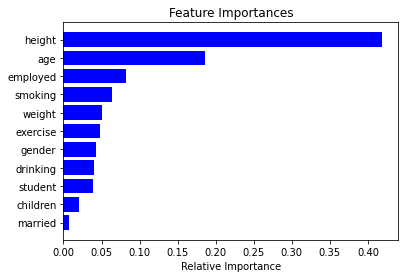

In [37]:
def calculate_feature_importances(data, labels, n_splits, test_size, seed, prep_params={}):
    model = Model(RandomForestRegressor, data, labels, n_splits, test_size, seed, prep_params)
    model.train()
    model.collect_best_stats()
    
    importances = model.best_estimator.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [df.columns.to_list()[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
calculate_feature_importances(data=data, labels=labels, n_splits=hp_cv_splits,
                              test_size=hp_test_size, seed=hp_seed,
                              prep_params={'scale':True, 'scale_columns':[0, 1, 10]})

# Model Definitions

## Linear Regression 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [17]:
# Add estimator
set_trainer.add_estimator('linear', LinearRegression)

## Support Vector Regression

[docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [18]:
# Add estimator
set_trainer.add_estimator('svr', SVR, {
    'kernel': ('linear', 'rbf', 'poly'),
    'C': [1.5, 10],
    'gamma': [1e-7, 1e-4],
    'epsilon': [0.1, 0.2, 0.3, 0.5]
})

## Bayesian Ridge

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html)

In [19]:
# Add estimator
set_trainer.add_estimator('br', BayesianRidge, {
    'n_iter': [300, 500, 700, 1000]
})

## kNN

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

In [20]:
# Add estimator
set_trainer.add_estimator('knn', KNeighborsRegressor, {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
})

## Decision Tree

[docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [21]:
# Add estimator
set_trainer.add_estimator('dt', DecisionTreeRegressor, {
    'criterion': ['squared_error', 'absolute_error'],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2]
})

## Bagging

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html)

In [22]:
# Add estimator
set_trainer.add_estimator('bag', BaggingRegressor, {
    'max_features': [3, 5, 7, 9, 11],
    'n_estimators': [10, 20, 50, 100],
})

## Random Forest

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [23]:
# Add estimator
set_trainer.add_estimator('rf', RandomForestRegressor, {
    'max_features': [3, 5, 7, 9, 11],
    'n_estimators': [100, 200, 500, 1000]
})

## XGBoost

[doc](https://xgboost.readthedocs.io/en/stable/parameter.html)

In [24]:
# Add estimator
set_trainer.add_estimator('xgb', XGBRegressor, {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 500, 1000],
    'subsample': [0.5, 0.75, 1],
})

## AdaBoost

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)

In [25]:
# Add estimator
set_trainer.add_estimator('ada', AdaBoostClassifier, {
    'loss': ['linear', 'square', 'exponential'],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 500, 1000],
})

## LGBM

[doc](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [26]:
# Add estimator
set_trainer.add_estimator('lgbm', LGBMRegressor, {
    'colsample_bytree': [0.4, 0.5, 0.6, 0.9, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 500, 1000],
})

## MLP

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

In [27]:
# Add estimator
set_trainer.add_estimator('mlp', MLPRegressor, {
    'early_stopping': [True],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'hidden_layer_sizes': [(8,8), (16,16), (64,64)],
    'batch_size': ['auto', 8, 16, 32, 64],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.003, 0.01],
})

# Training

## Trainer Definitions

### Default Trainer

In [28]:
prep_params = {'scale': False}

set_trainer.add_trainer(name='default', data=data, labels=labels, n_splits=hp_cv_splits,
                        test_size=hp_test_size, seed=hp_seed, prep_params=prep_params)

### Normalized Trainer

In [29]:
prep_params = {'scale': True, 'scale_columns': [0, 1, 10]}

set_trainer.add_trainer(name='normalized', data=data, labels=labels, n_splits=hp_cv_splits,
                        test_size=hp_test_size, seed=hp_seed, prep_params=prep_params)

### Feature Selected Trainer

In [30]:
prep_params = {'scale': True, 'scale_columns': [0, 1, 7]}
fselected_data = np.delete(data, [6, 7, 8], 1) # drop married, children and student

set_trainer.add_trainer(name='fselected', data=fselected_data, labels=labels, n_splits=hp_cv_splits,
                        test_size=hp_test_size, seed=hp_seed, prep_params=prep_params)

### Training

In [34]:
#set_trainer.run_all_trainers()

set_trainer.default.train_estimator('linear', reset=True)
set_trainer.normalized.train_estimator('linear', reset=True)
set_trainer.fselected.train_estimator('linear', reset=True)

In [ ]:
# Show stats.
#set_trainer.print_stats('linear')

# Show predicts.
#set_trainer.get_results_dataframe('linear', ascending=True).head()